#  Payment default prediction by Neural Network: Utilizing TensorFlow

This dataset includes data on bill statements, demographic information, credit data, payment history, and default payments for credit card users in Taiwan from April 2005 to September 2005. The main objective here is to forecast payment default for the following month.

In [1]:
# Import General Libraries 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# 1. Data Inspection

A initial study of the data reveals 30000 rows of information in 25 columns with 23 features. Preprocessing and replacement are not particularly necessary because the data is comparatively clean.

In [2]:
# Loading Data
data = pd.read_csv('uci_credit_card.csv')
# Inspecting Data; Preliminary Review 
data.info()
print('------------------------')



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

# 2. Visual Exploratory Data Analysis

In this section, all features are visualized based on their total and default distribution.

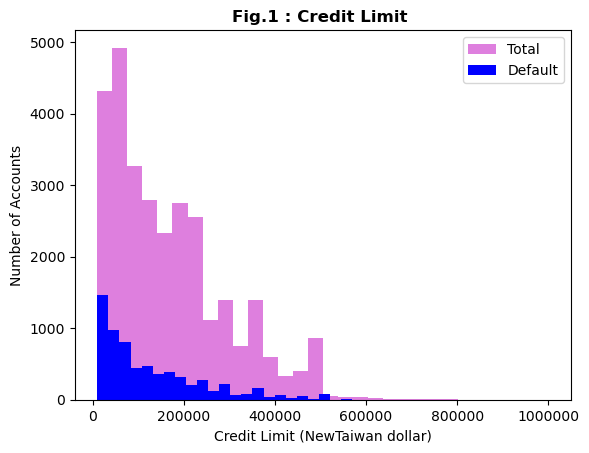

In [3]:
# Credit Limit (Feature name :'LIMIT_BAL' ) 
%matplotlib inline
bins = 30
plt.hist(data.LIMIT_BAL, bins = bins, color='m',label = 'Total',alpha=0.5)
plt.hist(data.LIMIT_BAL[data['default.payment.next.month'] == 1], bins = bins, color='b',label = 'Default')

plt.xlabel('Credit Limit (NewTaiwan dollar)');plt.ylabel('Number of Accounts')
plt.title('Fig.1 : Credit Limit ',fontweight="bold", size=12)
plt.ticklabel_format(style='plain')
plt.legend();plt.show()

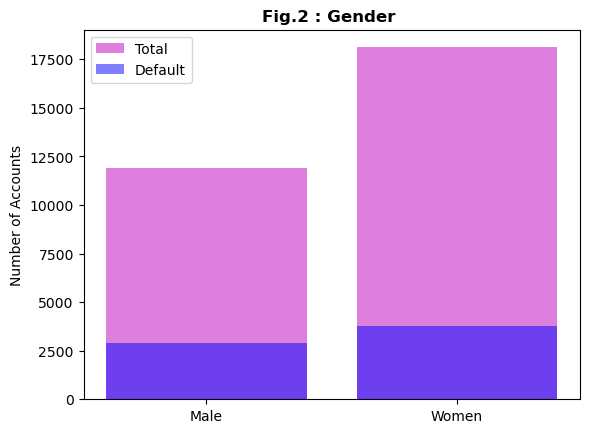

In [4]:
# Gender (Feature name :'SEX' )
men = data['SEX'][data['SEX']==1].count()
men_default = data['SEX'][(data['SEX']==1)&(data['default.payment.next.month']==1)].count()

women = data['SEX'][data['SEX']==2].count()
women_default = data['SEX'][(data['SEX']==2)&(data['default.payment.next.month']==1)].count()

total_sex = [men, women]
default_sex = [men_default,women_default]
gender = [1,2]
plt.bar(gender,total_sex, color='m',alpha=0.5, label='Total')
plt.bar(gender,default_sex, color='b',alpha=0.5, label='Default')

plt.xticks([1,2],['Male','Women']);plt.ylabel('Number of Accounts')
plt.title('Fig.2 : Gender ',fontweight="bold", size=12)
plt.legend();plt.show()

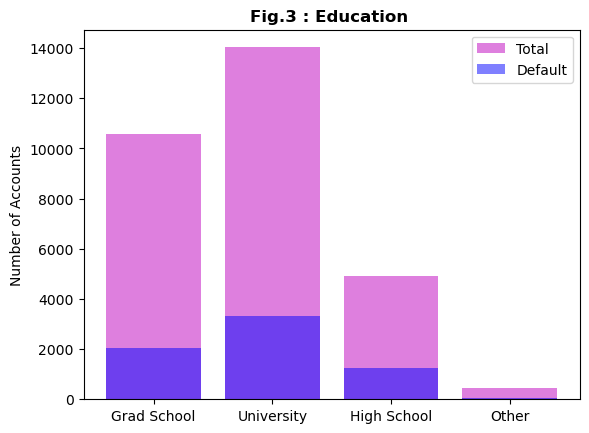

In [5]:
# Education (Feature name :'EDUCATION' )
grad =  data['EDUCATION'][data['EDUCATION']==1].count()
grad_default = data['EDUCATION'][(data['EDUCATION']==1)&(data['default.payment.next.month']==1)].count()

uni =  data['EDUCATION'][data['EDUCATION']==2].count()
uni_default = data['EDUCATION'][(data['EDUCATION']==2)&(data['default.payment.next.month']==1)].count()

high =  data['EDUCATION'][data['EDUCATION']==3].count()
high_default = data['EDUCATION'][(data['EDUCATION']==3)&(data['default.payment.next.month']==1)].count()

other =  data['EDUCATION'][data['EDUCATION'] > 3].count()
other_default = data['EDUCATION'][(data['EDUCATION'] > 3)&(data['default.payment.next.month']==1)].count()

total_education = [grad, uni, high, other]
default_education = [grad_default,uni_default,high_default, other_default]
degree = [1,2,3,4]
plt.bar(degree,total_education, color='m',alpha=0.5, label='Total')
plt.bar(degree,default_education, color='b',alpha=0.5, label='Default')

plt.xticks([1,2,3,4],['Grad School','University','High School','Other'])
plt.ylabel('Number of Accounts');plt.title('Fig.3 : Education ',fontweight="bold", size=12)
plt.legend();plt.show()

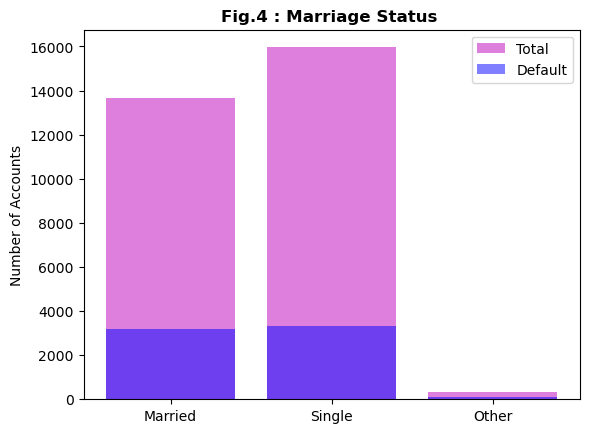

In [6]:
# Marriage Status (Feature name :'MARRIAGE')
married =  data['MARRIAGE'][data['MARRIAGE']==1].count()
married_default = data['MARRIAGE'][(data['MARRIAGE']==1)&(data['default.payment.next.month']==1)].count()

single =  data['MARRIAGE'][data['MARRIAGE']==2].count()
single_default = data['MARRIAGE'][(data['MARRIAGE']==2)&(data['default.payment.next.month']==1)].count()

other =  data['MARRIAGE'][data['MARRIAGE']==3].count()
other_default = data['MARRIAGE'][(data['MARRIAGE']==3)&(data['default.payment.next.month']==1)].count()

total_marriage = [married, single, other]
default_marriage = [married_default,single_default,other_default]
status = [1,2,3]
plt.bar(status,total_marriage, color='m',alpha=0.5, label='Total')
plt.bar(status,default_marriage, color='b',alpha=0.5, label='Default')

plt.xticks([1,2,3],['Married','Single','Other']); plt.ylabel('Number of Accounts')
plt.title('Fig.4 : Marriage Status ',fontweight="bold", size=12)
plt.legend(); plt.show()

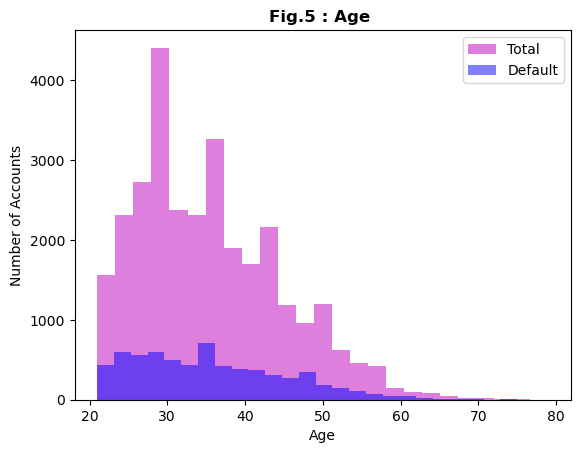

In [7]:
# Age (Feature name :'AGE' )
bins = 25

plt.hist(data['AGE'],bins = bins, color='m',label = 'Total',alpha=0.5)
plt.hist(data['AGE'][data['default.payment.next.month']==1], bins = bins, color='b',label = 'Default',alpha=0.5)

plt.xlabel('Age'); plt.ylabel('Number of Accounts')
plt.title('Fig.5 : Age ',fontweight="bold", size=12)
plt.legend();plt.show()

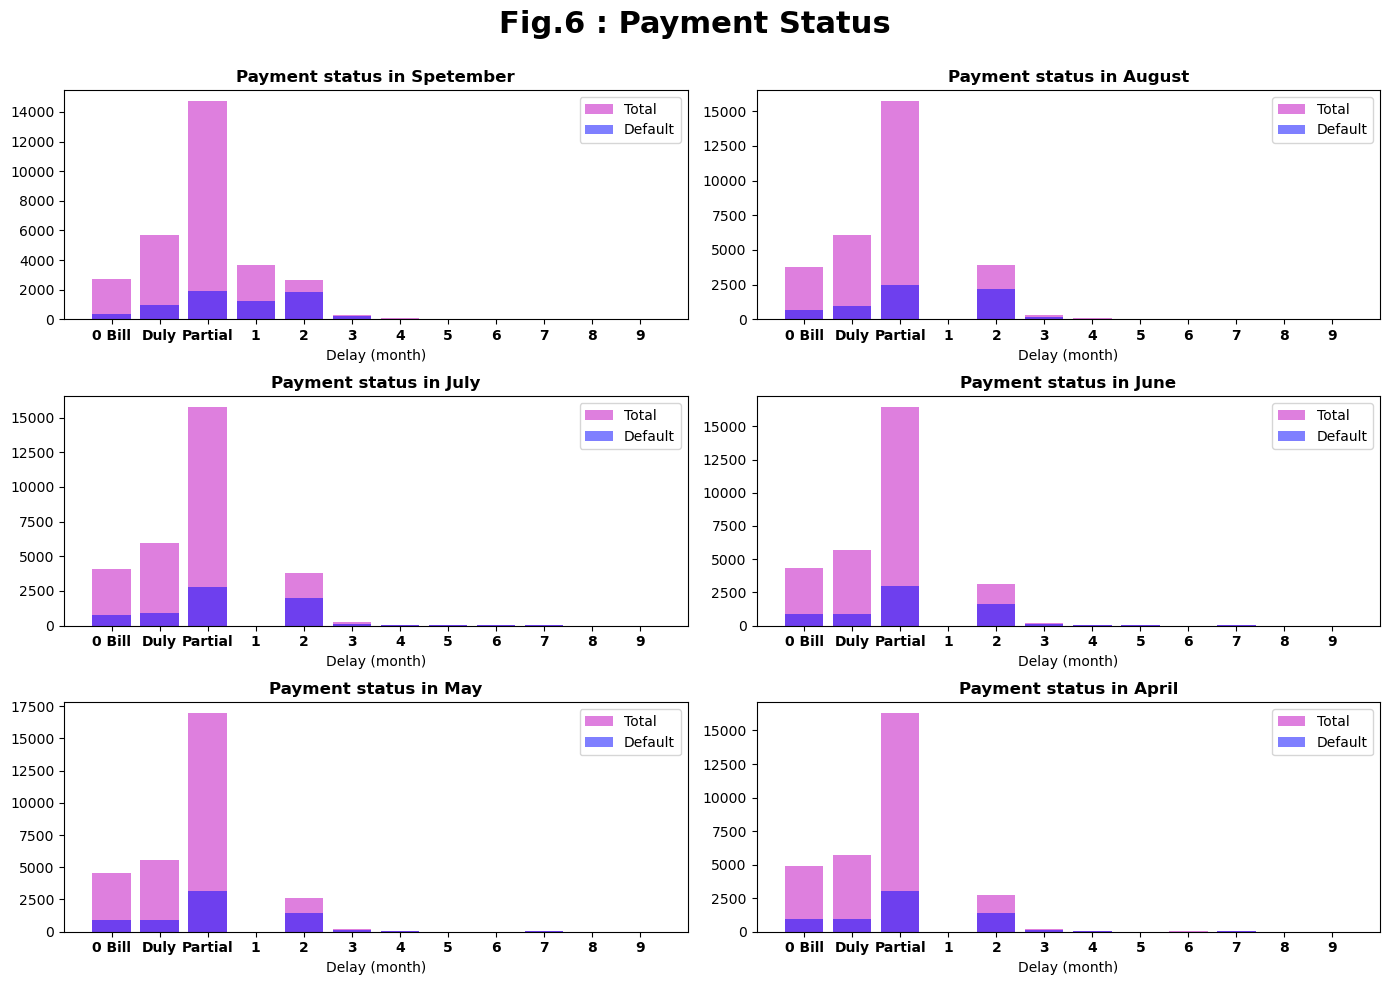

In [8]:
# Payment status (Feature name :'PAY_' )
import matplotlib.gridspec as gridspec
features = list(data.columns)
plt.figure(figsize=(14,10))

gs = gridspec.GridSpec(3,2)
i = 0

plt.suptitle('Fig.6 : Payment Status',fontweight="bold", fontsize=22)
for cn in features[6:12]:
    ax = plt.subplot(gs[i])
    delay = np.zeros(12)
    delay_default = np.zeros(12)  
    for j in np.arange(0,12):
            delay[j] = data[cn][data[cn]==j-2].count()
            delay_default[j] = data[cn][(data[cn]==j-2)&(data['default.payment.next.month']==1)].count()  

    month = [-2,-1,0,1,2,3,4,5,6,7,8,9]
    plt.bar(month,delay, color='m',alpha=0.5, label='Total')
    plt.bar(month,delay_default, color='b',alpha=0.5, label='Default')

    plt.xticks([-2,-1,0,1,2,3,4,5,6,7,8,9],['0 Bill','Duly','Partial','1','2','3','4','5','6','7','8','9'], fontweight="bold", size=10)
    ax.set_xlabel('Delay (month)')
    months = ['Spetember','August','July','June','May','April']
    ax.set_title('Payment status in ' + months[i], fontweight="bold", size=12)
    ax.legend()
    i+=1
    
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

### Note: 
According to the metadata description, a value of -1 denotes "pay duly," while a value of 1–9 denotes months of payment delay. Further investigation, however, reveals that the value of -2 is connected to a bill amount of zero and the value of 0 is connected to a partial bill payment. These two traits are among the major categories, as the preceding statistic plainly shows, and shouldn't be disregarded.   


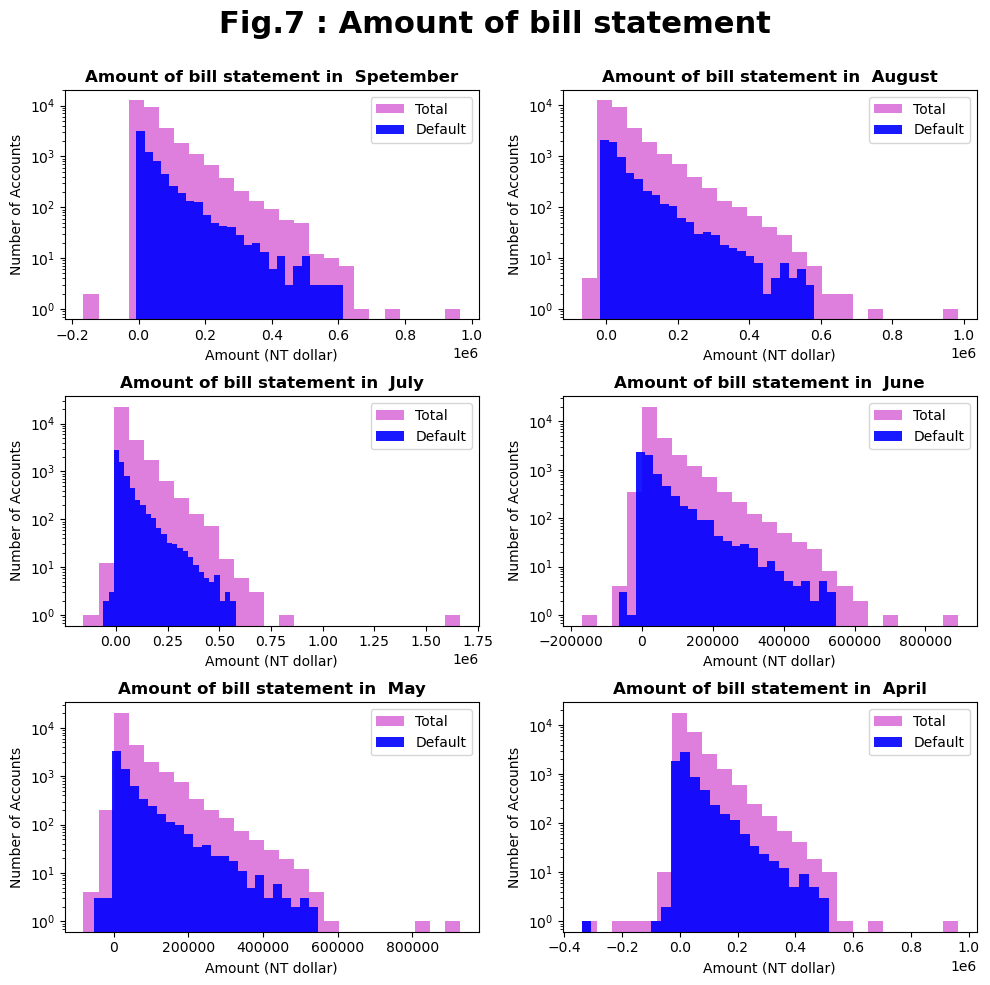

In [9]:
# Amount of bill statement (Feature name :'BILL_AMT_' )

features = list(data.columns)
plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3,2)
i = 0
plt.suptitle('Fig.7 : Amount of bill statement',fontweight="bold", fontsize=22)
for cn in features[12:18]:
    ax = plt.subplot(gs[i])
    bins = 25
    plt.hist(data[cn],bins = bins, color='m',label = 'Total',alpha=0.5)
    plt.hist(data[cn][data['default.payment.next.month']==1], bins = bins, color='b',label = 'Default',alpha=0.9)

    plt.xlabel('Amount (NT dollar)')
    plt.ylabel('Number of Accounts')
    ax.set_yscale('log',)

    months = ['Spetember','August','July','June','May','April']
    ax.set_title('Amount of bill statement in  ' + months[i], fontweight="bold", size=12)
    ax.legend()
    i+=1  
    plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

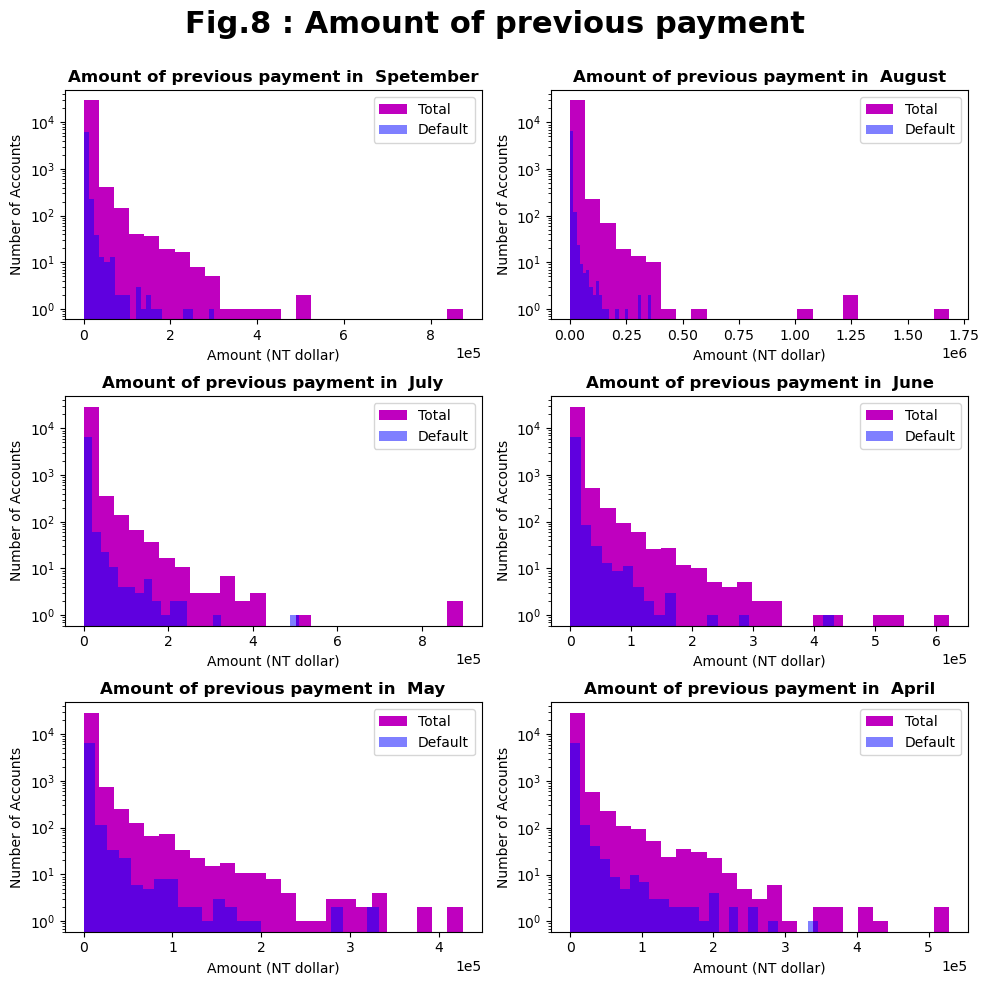

In [10]:
# Amount of previous payment (Feature name :'PAY_AMT_' )
features = list(data.columns)
plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(3,2)
i = 0
plt.suptitle('Fig.8 : Amount of previous payment',fontweight="bold", fontsize=22)
for cn in features[18:24]:
    ax = plt.subplot(gs[i])
    bins = 25
    plt.hist(data[cn],bins = bins, color='m',label = 'Total',alpha=1)
    plt.hist(data[cn][data['default.payment.next.month']==1], bins = bins, color='b',label = 'Default',alpha=0.5)

    plt.xlabel('Amount (NT dollar)')
    plt.ylabel('Number of Accounts')
    ax.set_yscale('log')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    months = ['Spetember','August','July','June','May','April']
    ax.set_title('Amount of previous payment in  ' + months[i], fontweight="bold", size=12)
    ax.legend()
    i+=1      
plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

Notice that figure 7 and 8 are on log scale and most of the time, there is at least one order of magnitude difference between total value and default's.

# 3. Feature Engineering
Understanding the nature of a feature's relationship with another feature and the final label can be done by calculating the pair correlation coefficient. The seaborn heat map can be used to more clearly see these coefficients.


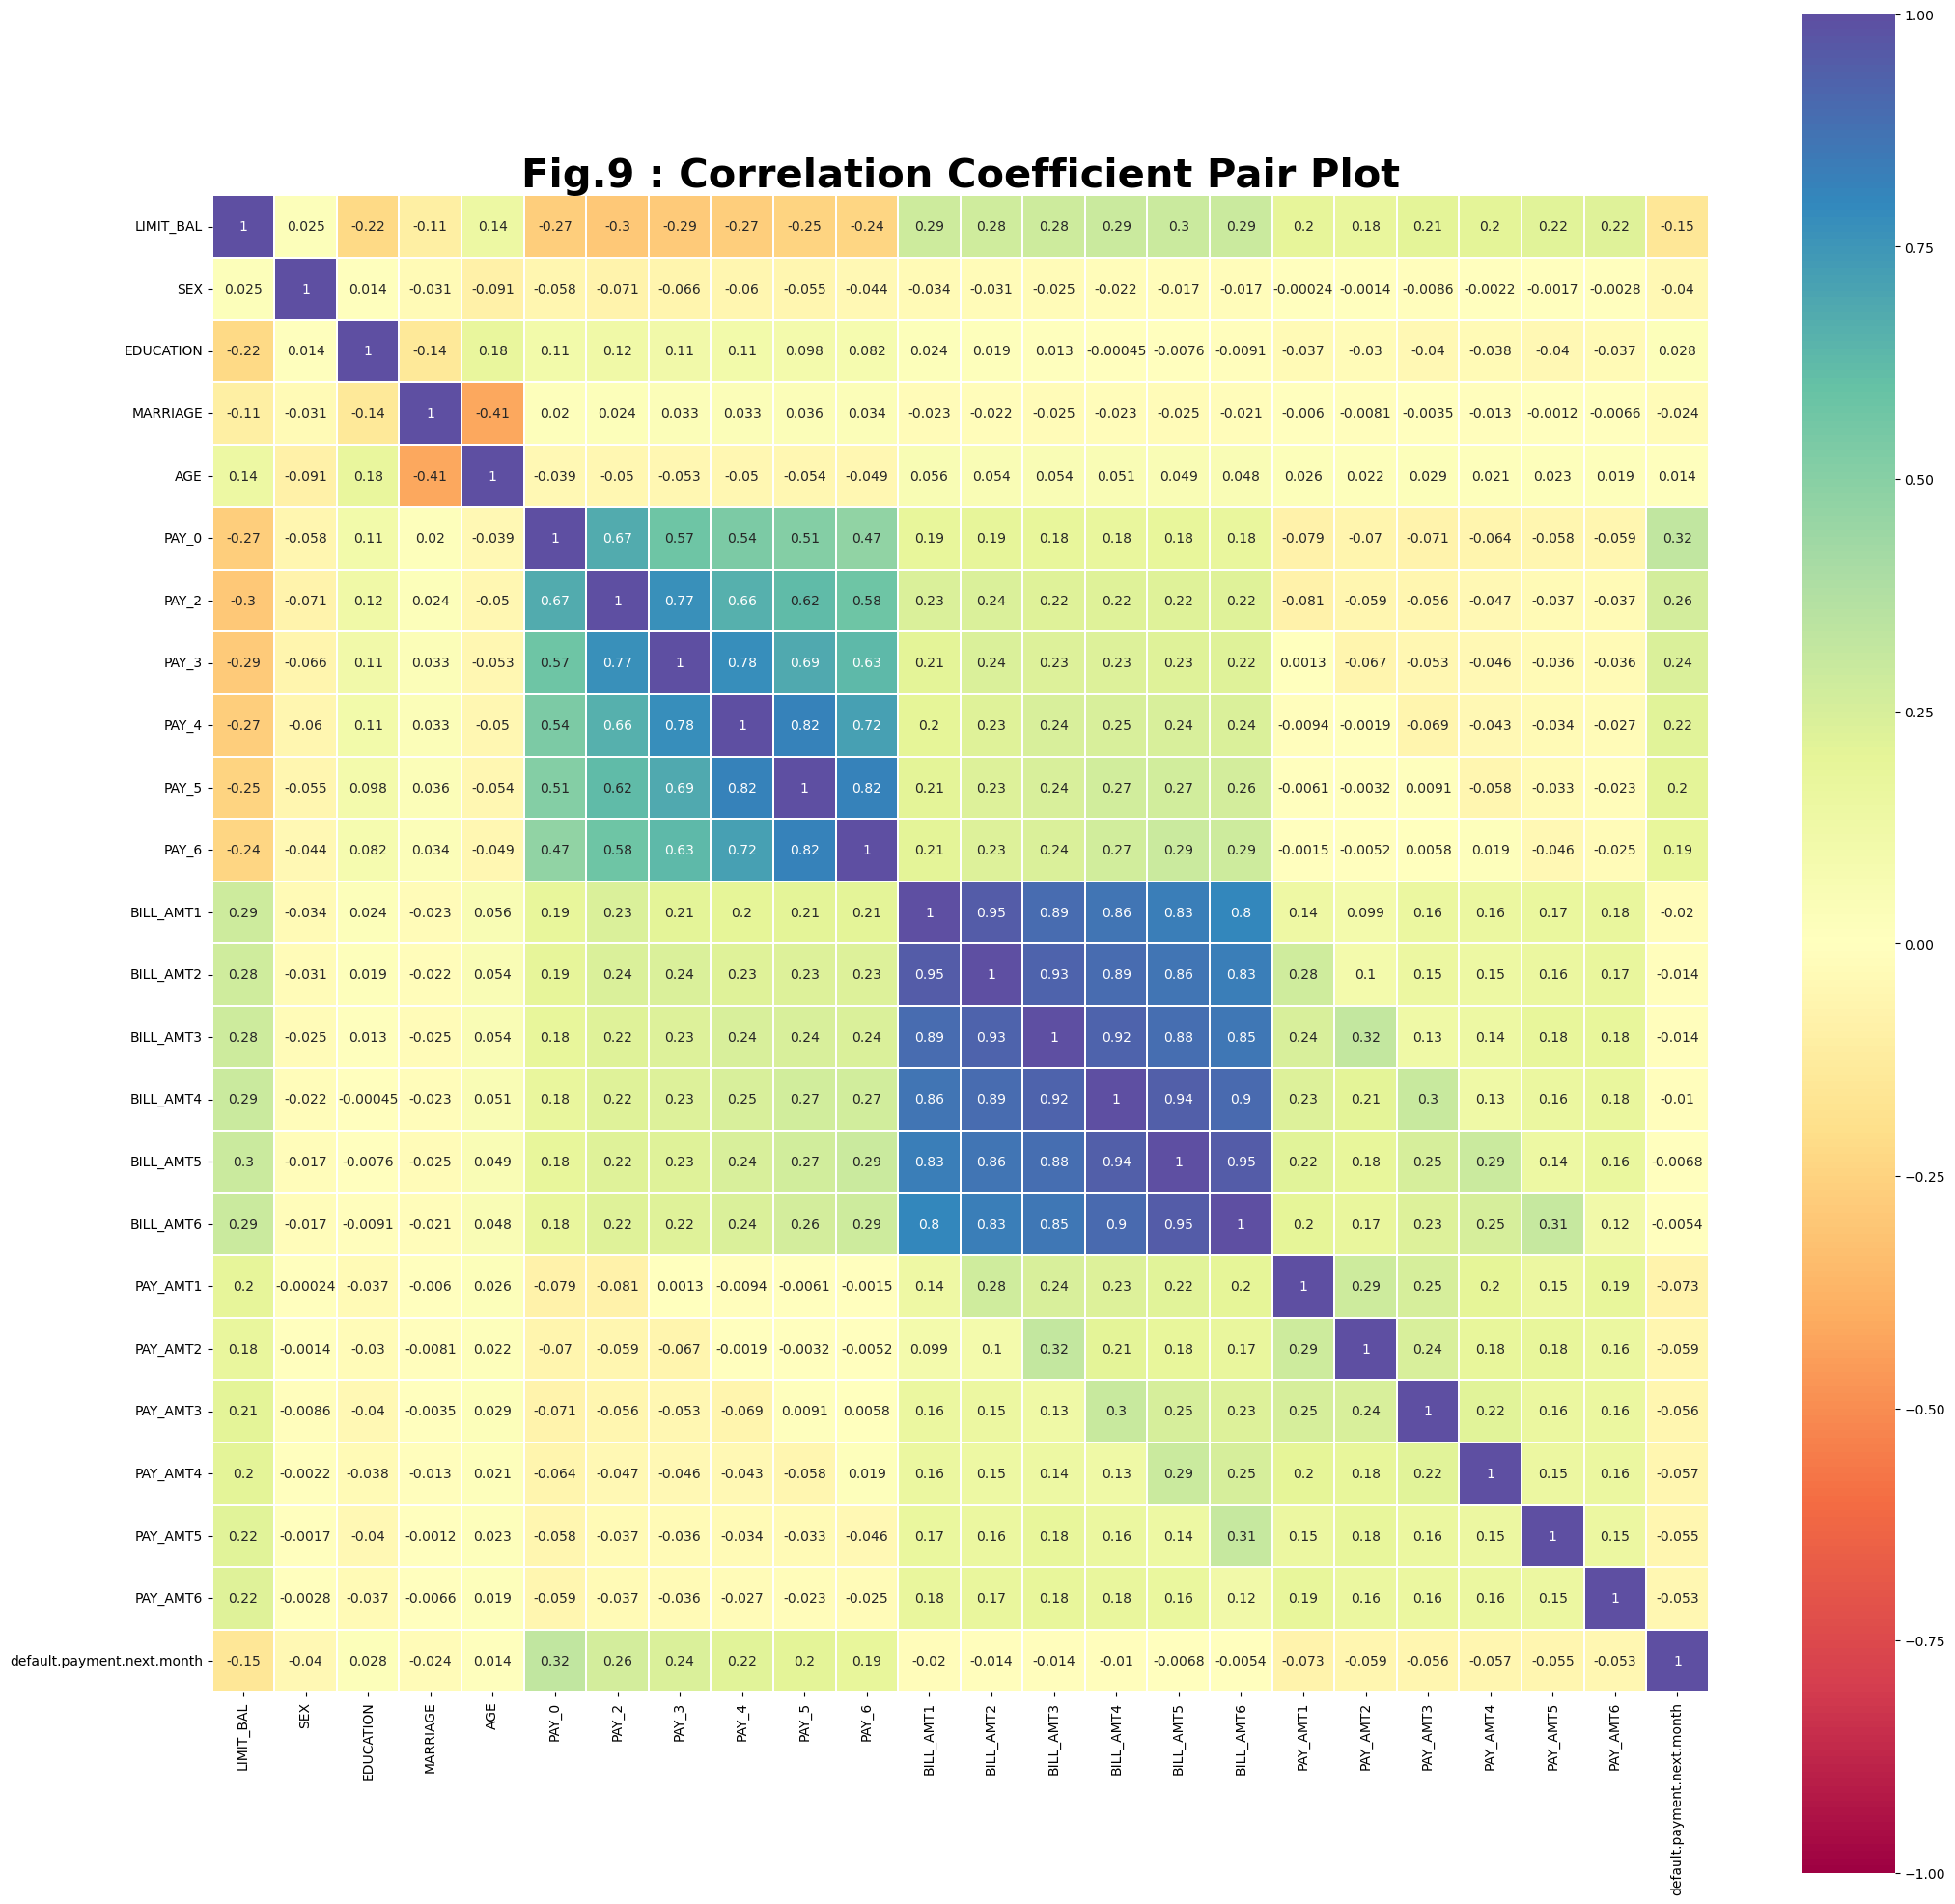

In [11]:
# Making correlation coefficients pair plot of all feature in order to identify degenrate features
plt.figure(figsize=(25,25))
ax = plt.axes()
corr = data.drop(['ID'], axis=1).corr()
sns.heatmap(corr, vmax=1,vmin=-1, square=True, annot=True, cmap='Spectral',linecolor="white", linewidths=0.01, ax=ax)
ax.set_title('Fig.9 : Correlation Coefficient Pair Plot',fontweight="bold", size=30)
plt.show()

Figure 9 demonstrates that although attributes linked to bill amount ('BILL AMT') have a strong correlation with one another, they only contribute minimally to the goal label ('default.payment.next.month'). One can remove these features if computational resources are constrained without significantly reducing prediction accuracy.

The features associated with payment status ('PAY') are likewise connected, but they also contribute most to the final label. The final column shows unequivocally that the importance of payment status grows as we approach closer to the current month.

However, at this time, all of these features are still intact and will be used directly in the deep learning model despite the interesting negative association between "SEX" and "MARRIAGE," which might be used to generate new features.


In [12]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

predictors = data.drop(['ID','default.payment.next.month'], axis=1).values
predictors = StandardScaler().fit_transform(predictors)

target = to_categorical(data['default.payment.next.month']) 

# 4. Deep Learning via Keras on Tensor Flow

In [13]:
# Deep Learning Libraries
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
import tensorflow as tf

Before feeding data to the model, it is recommended to find out about different class portion in the original data-set.

In [14]:
# Calculating default Ratio
non_default = len(data[data['default.payment.next.month']==0])
default = len(data[data['default.payment.next.month']==1])
ratio = float(default/(non_default+default))
print('Default Ratio :',ratio)

Default Ratio : 0.2212


Here, it is evident that the default class appears in only 22%, which results in imbalance data. As described below, this issue can be addressed by imposing proportional weight loss, while fitting the model.

## 4.1 Model Specification

input_shape : Number of input nodes (n_cols).

Model Type : Sequential (Each layer is only in direct contact with the next layer).

Dense Layers : Each node in current layer is in contact with all nodes in the next layer.

Activation : Activation function between the layers ( 'relu' for regression and  'softmax' for classification)
                    softmax produces total probability equals to one so that can be used for classification.    

## 4.2 Compiling the Model

optimaizer : Adjust learning rate  to its optimum  value for gradient decent ( 'adam' ).

Loss : Defines loss function ( 'categorical_crossentropy' for classification and 'mean_squared_error' for regression).

## 4.3 Fitting the Model 

early_stopping_monitor : Stop training when validation is not improving.

patience : How many epoch can go without improving.

Validation_split : splitting the data to train and test and validating based on model performance on test data-set

Class Weight: Forces algorithm to treat imbalance data proportionally 


In [15]:

n_cols = predictors.shape[1]
early_stopping_monitor = EarlyStopping(patience=2)
class_weight = {0:ratio, 1:1-ratio}

model = Sequential()
model.add(Dense(25, activation='relu', input_shape = (n_cols,)))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                600       
_________________________________________________________________
dense_1 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_3 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 52        
Total params: 2,602
Trainable params: 2,602
Non-trainable params: 0
_________________________________________________________________


In [16]:

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
history = model.fit(predictors, target, epochs=20, validation_split=0.3, callbacks = [early_stopping_monitor],class_weight=class_weight)

Epoch 1/20
657/657 [==============================] - 5s 3ms/step - loss: 0.2127 - accuracy: 0.6958 - val_loss: 0.5667 - val_accuracy: 0.7814
Epoch 2/20
657/657 [==============================] - 2s 3ms/step - loss: 0.2035 - accuracy: 0.7519 - val_loss: 0.5482 - val_accuracy: 0.7778
Epoch 3/20
657/657 [==============================] - 2s 3ms/step - loss: 0.2008 - accuracy: 0.7502 - val_loss: 0.5127 - val_accuracy: 0.7960
Epoch 4/20
657/657 [==============================] - 2s 3ms/step - loss: 0.1991 - accuracy: 0.7539 - val_loss: 0.5552 - val_accuracy: 0.7702
Epoch 5/20
657/657 [==============================] - 2s 3ms/step - loss: 0.1978 - accuracy: 0.7504 - val_loss: 0.5221 - val_accuracy: 0.7859


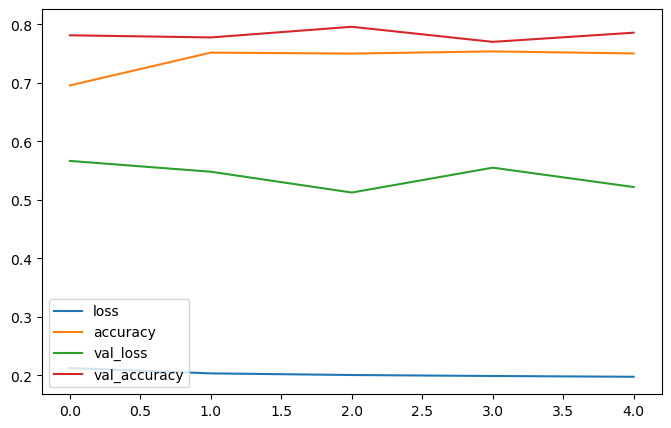

In [17]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.show()

# 5. Model Optimization

In [18]:
optimization = pd.DataFrame()
optimization['Hidden Layer'] = [1,1,1,2,2,3]
optimization['Node per Layer'] = [25,50,100,25,50,25]
optimization['val_loss'] = [0.1874,0.1871,0.1876,0.1861,0.1875,0.1881]

#print(optimization.to_string(index=False))
optimization.head(6)

,Hidden Layer,Node per Layer,val_loss
0,1,25,0.1874
1,1,50,0.1871
2,1,100,0.1876
3,2,25,0.1861
4,2,50,0.1875
5,3,25,0.1881


Above table shows that despite using higher capacity (larger number of nodes and layers), the optimum node number is about 50 and best validation loss is achieved by 2 layers. 